# Predicting Disease Associate Genes Relationship (Part 1)

This notebook is designed to begin the process of predicting the disease associates gene (DaG) relationship. The first step this notebook takes is labeling our training sentences (split = 0) using our hand crafted label functions. Following the labeling process, the next step is to train a generative model to estimate the most likely training class ($\hat{Y}$) given the output of our label functions. From there the last step is to train word embedding vectors using facebook's [FastText](https://fasttext.cc/). These word embedding vectors will be used in part 2 where we train the discriminator models to make the final classification.

## Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

# Bayesian Optimization
from hyperopt import fmin, hp, tpe, Trials

from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

sys.path.append(os.path.abspath('data/label_functions'))
from disease_gene_lfs import DG_LFS

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = False

## Load the Data and Label the  Sentences

This block of code is designed to label the sentences using our label functions. All the sentences are located in our postgres database that is store locally on the lab machine. The labeling process is defined as follows: Given a candidate id, we use the sqlalchemy library to extract a candidate object. Using this object and we pass it through a series of label functions that will output a 1 (positive), -1 (negative) or 0 (abstain) depending on the rule set. Lastly we aggregate the output of these functions into a sparse matrix that the generative model will use. Since these steps are pretty linear, we parallelized this process using python's multithreading library. Despite the optimization, this process can still take greater than 3 hours to label a set of ~600000 sentences.

In [6]:
total_candidates_df = pd.read_table("../dataset_statistics/data/all_dg_candidates_map.tsv.xz")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,1.0,2.0,78840952,We revealed that A1BG and LRG1 were overexpres...,30,26725291
1,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,1.0,1.0,86234572,METHODS: HEK293 cells expressing specific indi...,53,29874761


In [7]:
spreadsheet_names = {
    'dev': 'data/sentences/sentence_labels_dev.xlsx',
    'test': 'data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 1000
Size of test set: 1000


In [9]:
#Save data for cluster
(
    candidate_dfs['dev'][["candidate_id", "curated_dsh"]]
    .to_csv("data/dev_labels.tsv", index=False, sep="\t")
)

In [10]:
lfs = list(DG_LFS["DaG"].values())
lf_names = list(DG_LFS["DaG"].keys())

In [11]:
if not quick_load:
    label_matricies = {
        'train':label_candidates(
            session, 
            (
                total_candidates_df
                .query("split==0&disease_mention_count==1&gene_mention_count==1")
                .candidate_id
                .values
                .tolist()
            ),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
    }

HBox(children=(IntProgress(value=0, max=658603), HTML(value='')))

 658382
      0

In [12]:
if not quick_load:
    # Check to make sure the label functions match up with the candidate objects
    ids=label_matricies['train'].candidate_id.head(5).tolist()
    candidate_list = session.query(DiseaseGene).filter(DiseaseGene.id.in_(ids)).all()
    for candidate in tqdm_notebook(candidate_list):
        correct_output = list(map(lambda fn: fn(candidate), lfs))
        test_output = label_matricies['train'].query("candidate_id==@candidate.id").fillna(0).values.tolist()[0]
        for pair in zip(correct_output, test_output[:-1]):
            assert pair[0] == pair[1]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [13]:
if not quick_load:
    label_matricies.update({
        key:label_candidates(
            session, 
            candidate_dfs[key]['candidate_id'].values.tolist(),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
        for key in candidate_dfs
    })

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

    990
      0

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

    990
      0

In [14]:
# Save the label matricies to a file for future loading/error analysis
if not quick_load:
    (
        label_matricies['train']
        .sort_values("candidate_id")
        .to_csv("data/train_sparse_matrix.tsv", sep="\t", index=False)
    )
    (
        label_matricies['dev']
        .sort_values("candidate_id")
        .to_csv("data/dev_sparse_matrix.tsv", sep="\t", index=False)
    )
    (
        label_matricies['test']
        .sort_values("candidate_id")
        .to_csv("data/test_sparse_matrix.tsv", sep="\t", index=False)
    )
# Quick load the label matricies
else:
    label_destinations = {
        'train':"data/train_sparse_matrix.tsv",
        'dev':"data/dev_sparse_matrix.tsv",
        'test':"data/test_sparse_matrix.tsv"
    }
    label_matricies = {
        key:pd.read_table(label_destinations[key]).to_sparse()
        for key in label_destinations
    }

In [15]:
# Important Note Snorkel Metal uses a different coding scheme
# than the label functions output. (2 for negative instead of -1).
# This step corrects this problem by converting -1s to 2
correct_L = plusminus_to_categorical(
    label_matricies['train']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)
correct_L_dev = plusminus_to_categorical(
    label_matricies['dev']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)
correct_L_test = plusminus_to_categorical(
    label_matricies['test']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)

In [16]:
lf_summary(
    sparse.coo_matrix(
        plusminus_to_categorical(
            label_matricies['train']
            .sort_values("candidate_id")
            .drop("candidate_id", axis=1)
            .to_coo()
            .toarray()
        )
    )
    .tocsr(), 
    lf_names=lf_names
)

,j,Polarity,Coverage,Overlaps,Conflicts
LF_HETNET_DISEASES,0,1,0.377833,0.377833,0.336896
LF_HETNET_DOAF,1,1,0.172154,0.172154,0.150771
LF_HETNET_DisGeNET,2,1,0.341907,0.341907,0.304578
LF_HETNET_GWAS,3,1,0.043166,0.043166,0.037683
LF_HETNET_DaG_ABSENT,4,2,0.510921,0.510921,0.491616
LF_DG_CHECK_GENE_TAG,5,2,0.239513,0.239513,0.234900
LF_DG_CHECK_DISEASE_TAG,6,2,0.375861,0.375861,0.367402
LF_DG_IS_BIOMARKER,7,1,0.165462,0.165462,0.140932
LF_DaG_ASSOCIATION,8,1,0.234982,0.234982,0.196100
LF_DaG_WEAK_ASSOCIATION,9,1,0.008548,0.008548,0.008548


In [17]:
lf_summary(
    sparse.coo_matrix(
        plusminus_to_categorical(
            label_matricies['dev']
            .sort_values("candidate_id")
            .drop("candidate_id", axis=1)
            .to_coo()
            .toarray()
        )
    )
    .tocsr(), 
    lf_names=lf_names, 
    Y=candidate_dfs['dev'].curated_dsh.apply(lambda x: 1 if x> 0 else 2)
)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_HETNET_DISEASES,0,1,0.432,0.432,0.414,164,268,0.379630
LF_HETNET_DOAF,1,1,0.206,0.206,0.198,80,126,0.388350
LF_HETNET_DisGeNET,2,1,0.388,0.388,0.369,144,244,0.371134
LF_HETNET_GWAS,3,1,0.050,0.050,0.047,24,26,0.480000
LF_HETNET_DaG_ABSENT,4,2,0.459,0.459,0.448,270,189,0.588235
LF_DG_CHECK_GENE_TAG,5,2,0.265,0.265,0.261,174,91,0.656604
LF_DG_CHECK_DISEASE_TAG,6,2,0.344,0.344,0.341,218,126,0.633721
LF_DG_IS_BIOMARKER,7,1,0.167,0.167,0.151,119,48,0.712575
LF_DaG_ASSOCIATION,8,1,0.258,0.258,0.249,178,80,0.689922
LF_DaG_WEAK_ASSOCIATION,9,1,0.022,0.022,0.022,13,9,0.590909


The two above cells contain statistics for each label function used in this notebook. The generated statistics contains information as to the polarity of a label function, how often one label function overlaps with another, how ofter one label function conflicts with another, and many much does a given label function cover. If gold standard labels are provided, then extra information such as empirical accuracy can be incorporated. Upon insepction we have a wide range of performance in terms of individual label functions. Some are very accurate and some are almost completely wrong. Nonetheless both types of functions are important because the main goal here is to provide as much evidence as possible to estimate the tinal training class.

## Begin Training the Generative Model

In this section, we are going to train a generative model. This model is designed to estimate the best class a training point belongs to given a set of label functions ($P(\hat{Y} \mid \lambda_{1\ldots n})$). This is accomplished by estimating a parameter called mu, which is the probability of a label function emitting a 1 or 2 given the true class. ($P(\lambda_{j} = y | Y=y)$). Once mu is estimated, the final step is to use mu and calculate the above probability ($P(\hat{Y} \mid \lambda_{1\ldots n})$). In order to find the best model, we will use hyperparameter optimization. This process involves trying multiple values keeping the value that provides the best result. The challenge with this process is that the search space is vast and can take non trivial time to navigate. As a consequence we resort to using advance methods called [bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to navigate this space in an effective way. The hyperparameter we are tuning is the l2 norm. This penalty term penalizes a machine learning classifier for the magnitude of the weights. By using this parameter we optimize the l2 norm for each label function individually. Luckily, the generative model is pretty fast to train, so this process won't take a significant amount of time.

# Distant Supervision

Here in this section we are using the distant superivion paradigm to label our candidate sentences.

In [18]:
def hyperparam_optimize(space, model, X, dev_X, dev_Y,lf_names, iterations=300):
    
    #Define the objective space to optimize
    def objective(params):
        #Randomly set up the parameters for the model to select
        l2=pd.np.fromiter(
            (params[key] for key in sorted(params.keys(), key=lambda x: int(x))),
            dtype=pd.np.float32
        )

        #Train the model
        model.train_model(
            X, n_epochs=1000, 
            print_every=200, seed=100, lr=0.01, 
            l2=l2, verbose=False
        )

        #Use accuracy score as the criteria
        score = model.score(
            (dev_X, dev_Y),
            verbose=False
        )
        # since search is design to minimize, change the sign
        return -score

    # Keep track of the trials
    trials = Trials()

    # Run the search!!
    best = fmin(
        fn=objective, space=space, algo=tpe.suggest, 
        max_evals=iterations, trials=trials, rstate=pd.np.random.RandomState(100)
    )
    return (
        pd.DataFrame(
            list(
                zip(
                    list(chain(*[(x+"_pos", x+"_neg") for x in lf_names])), 
                    [best[key] for key in sorted(best.keys(), key=lambda x: int(x))]
                )
            ), 
            columns=["label_function", "regularization"]
        ), 
        trials
    )

In [19]:
search_space = {
        str(key):hp.uniform(str(key), 0, 10)
        for key in range(len(lf_names[0:7])*2)
    }
distant_supervision_reg_df, ds_trials = hyperparam_optimize(
    search_space, LabelModel(k=2),
    X=correct_L[:,0:7], dev_X=correct_L_dev[:,0:7],
    dev_Y=candidate_dfs['dev'].curated_dsh.apply(lambda x: 1 if x > 0 else 2).values,
    lf_names=lf_names[0:7], iterations=500
)
distant_supervision_reg_df.head(2)

,label_function,regularization
0,LF_HETNET_DISEASES_pos,0.003408
1,LF_HETNET_DISEASES_neg,2.639444


Text(0.5,1,'L2 Param for Each Label Function')

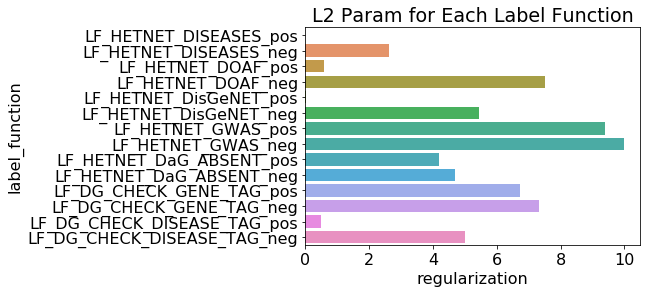

In [112]:
ax = sns.barplot(y="label_function", x="regularization", data=distant_supervision_reg_df)
ax.set_title("L2 Param for Each Label Function")

In [21]:
data = []
sampled_values = []
for trial in ds_trials.trials:
    data.append((trial['tid'], -trial['result']['loss']))
    sampled_values.append(list(map(lambda x: (trial['tid'], int(x[0]), x[1][0]), trial['misc']['vals'].items())))

sampled_values_df = pd.DataFrame(list(chain(*sampled_values)), columns=['iterations', 'param','value'])
trial_results_df = pd.DataFrame(data, columns=['iterations', 'acc'])
trial_results_df = (
    trial_results_df
    .assign(
        hue=trial_results_df.acc.apply(lambda x: True if x==trial_results_df.acc.max() else False).values
    )
)
trial_results_df.head(2)

,iterations,acc,hue
0,0,0.491,False
1,1,0.479,False


Text(0.5,1,'Bayeisan Op Trial Results')

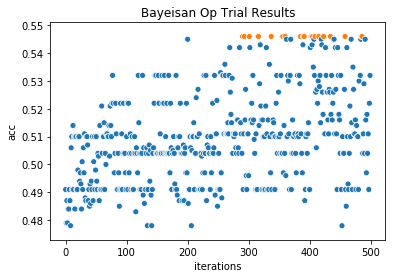

In [22]:
ax = sns.scatterplot(x='iterations', y='acc', hue='hue', data=trial_results_df, legend=None)
ax.set_title("Bayeisan Op Trial Results")

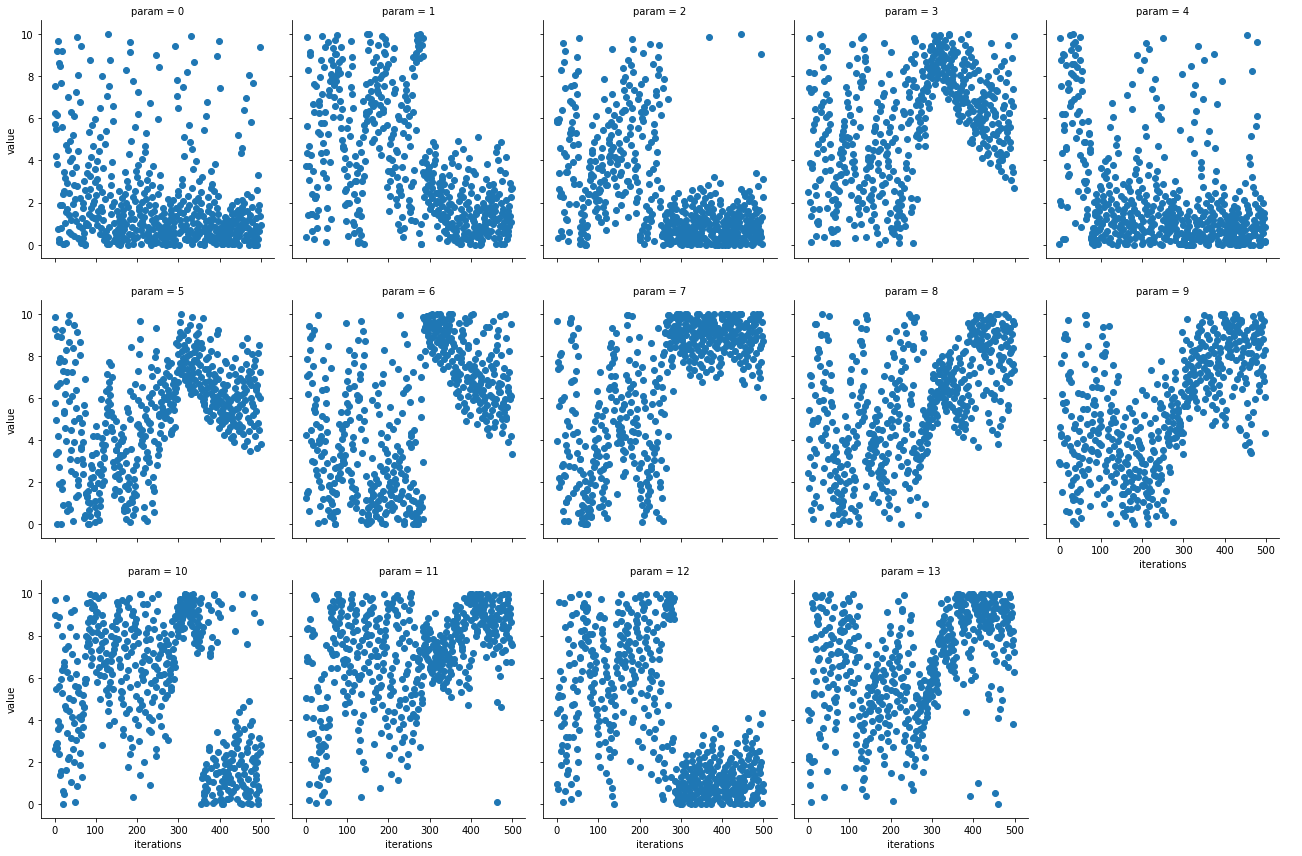

In [23]:
g = sns.FacetGrid(sampled_values_df.sort_values("param"), col='param', height=4, aspect=0.9, col_wrap=5)
g.map(plt.scatter, "iterations", "value").add_legend()

In [24]:
# Train best model
label_model = LabelModel(k=2)
label_model.train_model(
        correct_L[:, 0:7], n_epochs=1000, 
        print_every=200, seed=100, lr=0.01, 
        l2=distant_supervision_reg_df.regularization.values.astype(pd.np.float32)
    )

Computing O...
Estimating \mu...
[E:0]	Train Loss: 0.283
[E:200]	Train Loss: 0.115
[E:400]	Train Loss: 0.115
[E:600]	Train Loss: 0.115
[E:800]	Train Loss: 0.115
[E:999]	Train Loss: 0.115
Finished Training


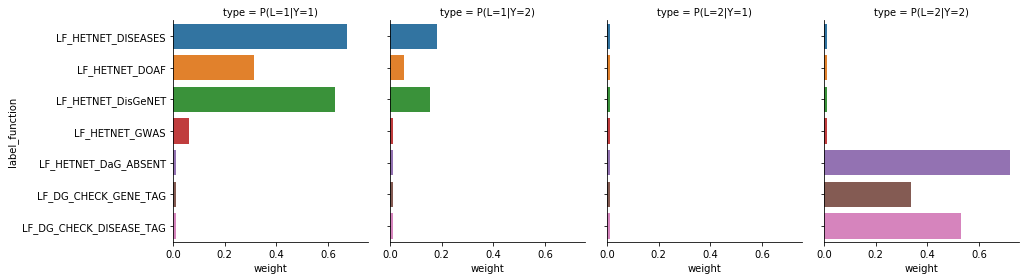

In [25]:
lf_stats = zip(lf_names[0:7], range(0,label_model.mu.detach().clone().numpy().shape[0],2))
estimated_param = pd.np.clip(label_model.mu.detach().clone().numpy(), 0.01, 0.99)
value_type = ["P(L=1|Y=1)", "P(L=1|Y=2)", "P(L=2|Y=1)", "P(L=2|Y=2)"]
data = []

for lf_name, lf_index in lf_stats:
    data+=list(zip([lf_name] * len(value_type), estimated_param[lf_index:lf_index+2, :].flatten(), value_type))
    
label_function_weight_df = pd.DataFrame(data, columns=["label_function", "weight", "type"])
ax=sns.catplot(
    y="label_function", x="weight", col="type", 
    data=label_function_weight_df, orient="h", kind="bar",
    height=4, aspect=0.9
)

The graph above shows the particular weights each label function has. Based on the polarity of each label function there are four categories: probability of a lf outputing a pos label given the true class is positive $P(L=1 \mid Y=1)$,  probability of a lf outputing a pos label given the true class is negative $P(L=1 \mid Y=2)$, probability of a lf outputing a neg label given the true class is positive $P(L=2 \mid Y=1)$ and probability of a lf outputting a neg label given the true class is negative $P(L=2 \mid Y=2)$. So far the weights look relatively logical; however, some of the positive label functions are providing evidence for the wrong class. This isn't a significant problem since the weights for wrong class are low, but this is a good sanity check in case undesired results arise. 

In [26]:
dev_pred_ds_df = pd.DataFrame(
    label_model.predict_proba(correct_L_dev[:, 0:7]),
    columns=["pos_class_marginal", "neg_class_marginal"]
).assign(candidate_id=label_matricies['dev'].candidate_id.tolist())
dev_pred_ds_df.head(2)

,pos_class_marginal,neg_class_marginal,candidate_id
0,0.799973,0.200027,21841
1,0.988795,0.011205,82680


In [27]:
test_pred_ds_df = pd.DataFrame(
    label_model.predict_proba(correct_L_test[:,0:7]),
    columns=["pos_class_marginal", "neg_class_marginal"]
).assign(candidate_id=label_matricies['test'].candidate_id.tolist())
test_pred_ds_df.head(2)

,pos_class_marginal,neg_class_marginal,candidate_id
0,0.065540,0.934460,23356
1,0.000414,0.999586,23367


# Distant Supervision With Text Patterns

Here in this section we incorporate more information such as text patterns, sentence context and other rules to sift through some of the noise caused by the general distant supervision approach.

In [28]:
search_space = {
        str(key):hp.uniform(str(key), 0, 10)
        for key in range(len(lf_names)*2)
    }
ds_text_reg_df, ds_text_trials = hyperparam_optimize(
    search_space, LabelModel(k=2),
    X=correct_L, dev_X=correct_L_dev,
    dev_Y=candidate_dfs['dev'].curated_dsh.apply(lambda x: 1 if x > 0 else 2).values,
    lf_names=lf_names, iterations=500
)
ds_text_reg_df.head(2)

,label_function,regularization
0,LF_HETNET_DISEASES_pos,0.896536
1,LF_HETNET_DISEASES_neg,9.662756


Text(0.5,1,'L2 Param for Each Label Function')

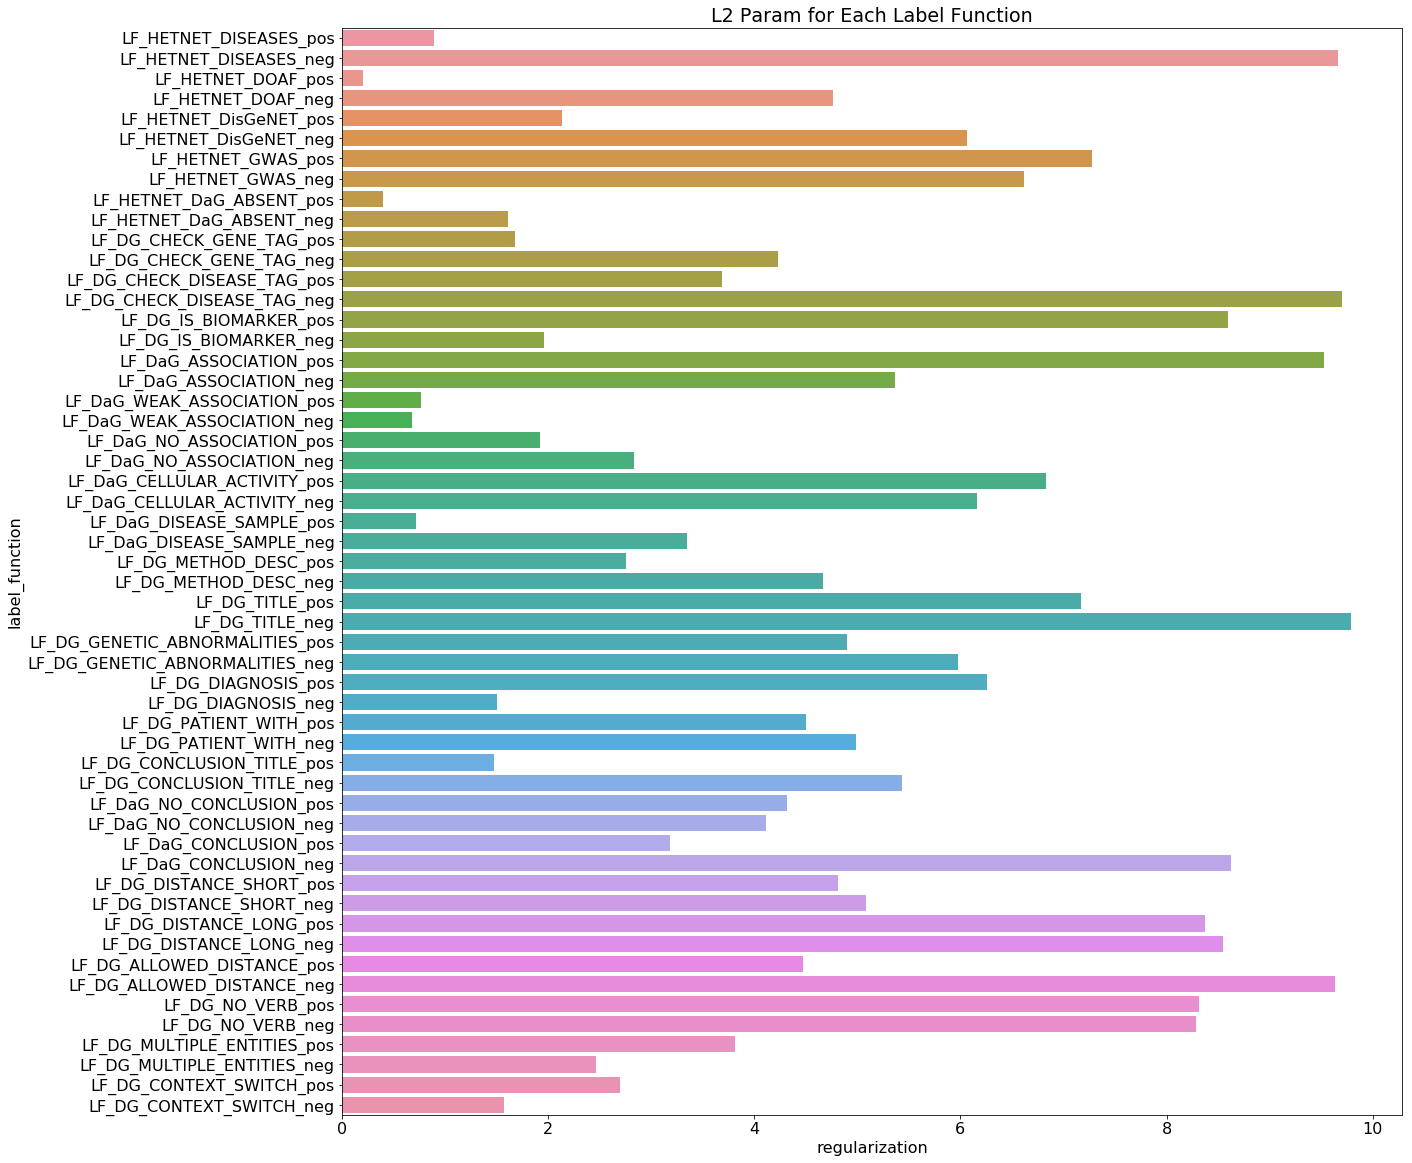

In [111]:
fig, ax = plt.subplots()
fig.set_size_inches(19,20)
sns.barplot(y="label_function", x="regularization", data=ds_text_reg_df, ax=ax)
ax.set_title("L2 Param for Each Label Function")

In [30]:
data = []
sampled_values = []
for trial in ds_text_trials.trials:
    data.append((trial['tid'], -trial['result']['loss']))
    sampled_values.append(list(map(lambda x: (trial['tid'], int(x[0]), x[1][0]), trial['misc']['vals'].items())))

sampled_values_df = pd.DataFrame(list(chain(*sampled_values)), columns=['iterations', 'param','value'])
trial_results_df = pd.DataFrame(data, columns=['iterations', 'acc'])
trial_results_df = (
    trial_results_df
    .assign(
        hue=trial_results_df.acc.apply(lambda x: True if x==trial_results_df.acc.max() else False).values
    )
)
trial_results_df.head(2)

,iterations,acc,hue
0,0,0.634,False
1,1,0.571,False


Text(0.5,1,'Bayeisan Op Trial Results')

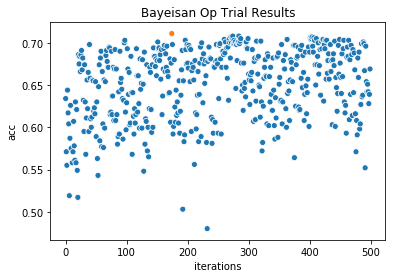

In [31]:
ax = sns.scatterplot(x='iterations', y='acc', hue='hue', data=trial_results_df, legend=None)
ax.set_title("Bayeisan Op Trial Results")

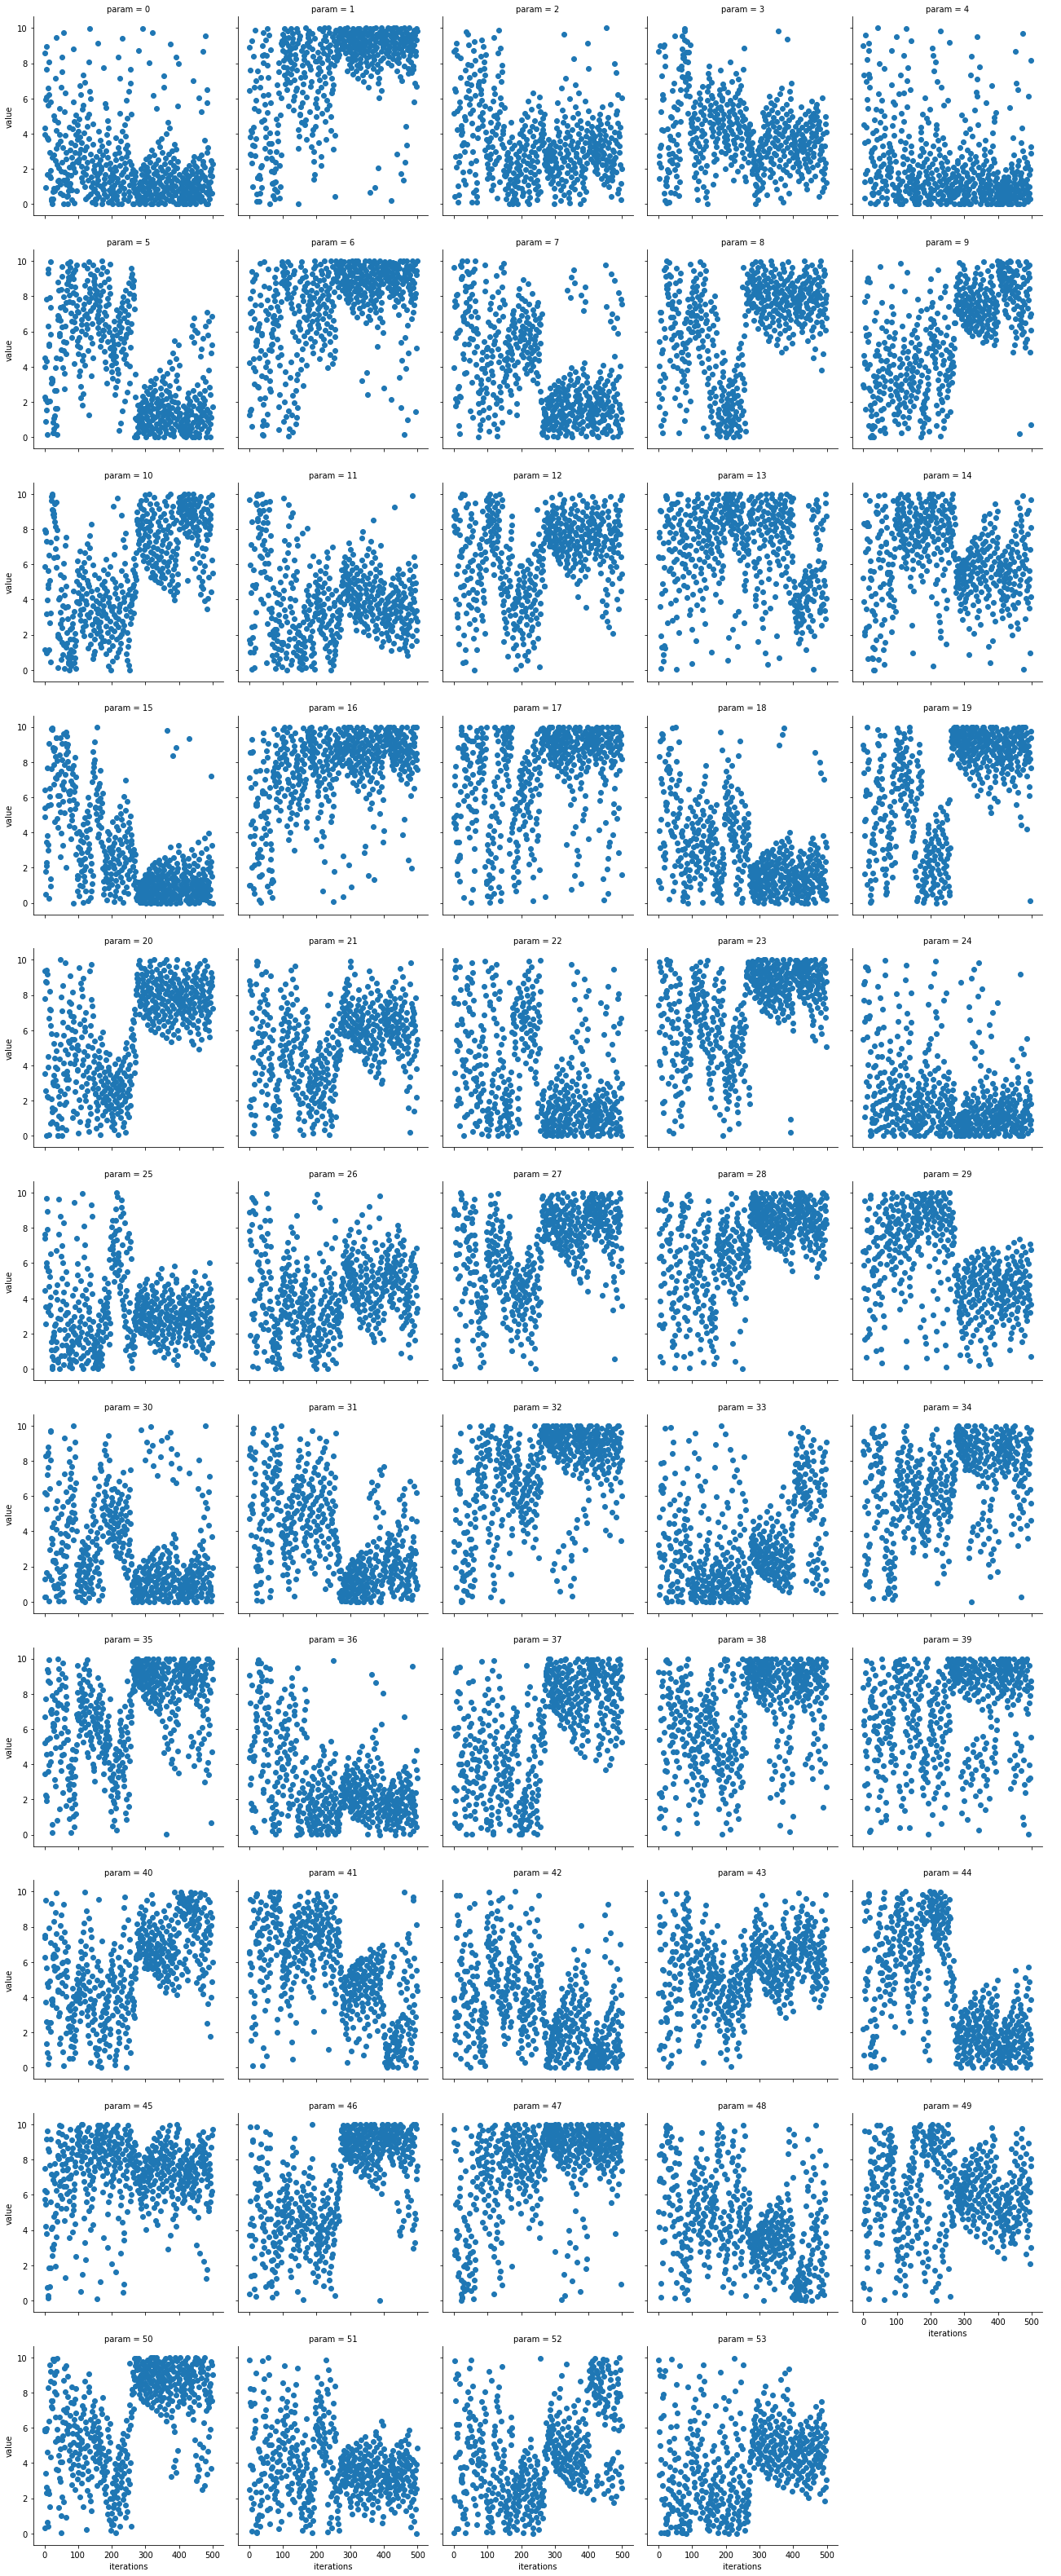

In [32]:
g = sns.FacetGrid(sampled_values_df.sort_values("param"), col='param', height=4, aspect=0.9, col_wrap=5)
g.map(plt.scatter, "iterations", "value").add_legend()

In [33]:
# Train best model
label_model = LabelModel(k=2)
label_model.train_model(
        correct_L, n_epochs=1000, 
        print_every=200, seed=100, lr=0.01, 
        l2=ds_text_reg_df.regularization.values.astype(pd.np.float32)
    )
label_model.score(
    (correct_L_dev, candidate_dfs['dev'].curated_dsh.apply(lambda x: 1 if x > 0 else 2).values)
)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 56.675
[E:200]	Train Loss: 2.297
[E:400]	Train Loss: 2.297
[E:600]	Train Loss: 2.297
[E:800]	Train Loss: 2.297
[E:999]	Train Loss: 2.297
Finished Training
Accuracy: 0.711
        y=1    y=2   
 l=1    247    139   
 l=2    150    464   


0.711

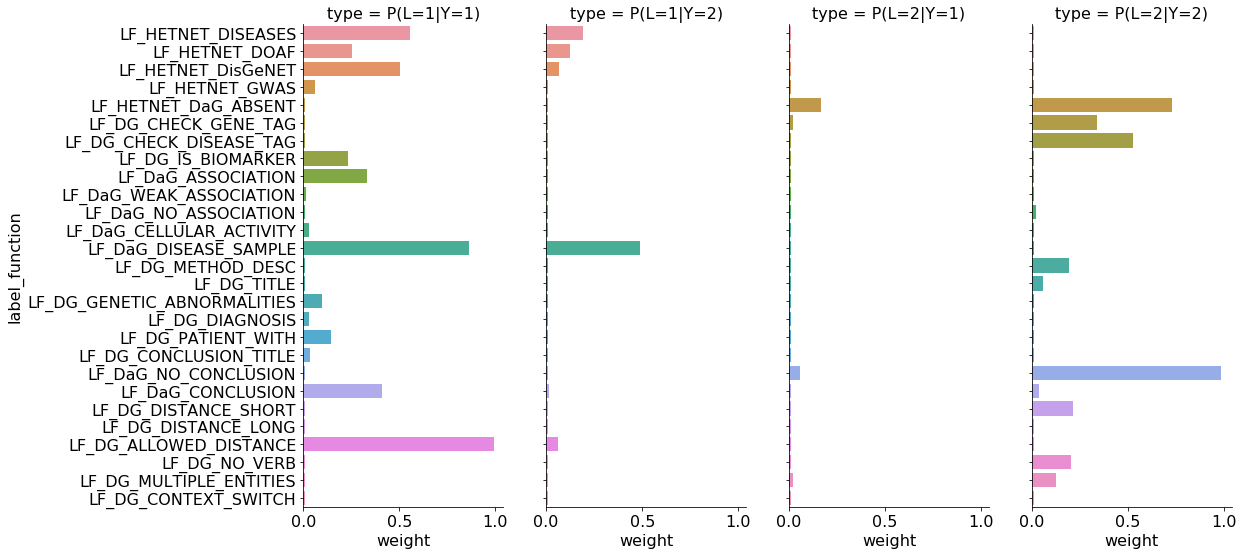

In [116]:
lf_stats = zip(lf_names, range(0,label_model.mu.detach().clone().numpy().shape[0],2))
estimated_param = pd.np.clip(label_model.mu.detach().clone().numpy(), 0.01, 0.99)
value_type = ["P(L=1|Y=1)", "P(L=1|Y=2)", "P(L=2|Y=1)", "P(L=2|Y=2)"]
data = []

for lf_name, lf_index in lf_stats:
    data+=list(zip([lf_name] * len(value_type), estimated_param[lf_index:lf_index+2, :].flatten(), value_type))
    
label_function_weight_df = pd.DataFrame(data, columns=["label_function", "weight", "type"])
ax=sns.catplot(
    y="label_function", x="weight", col="type", 
    data=label_function_weight_df, orient="h", kind="bar",
    height=8, aspect=0.55
)

In [35]:
dev_pred_ds_txt_df = pd.DataFrame(
    label_model.predict_proba(correct_L_dev),
    columns=["pos_class_marginal", "neg_class_marginal"]
).assign(candidate_id=label_matricies['dev'].candidate_id.tolist())
dev_pred_ds_txt_df.head(2)

,pos_class_marginal,neg_class_marginal,candidate_id
0,0.961816,0.038184,21841
1,0.367907,0.632093,82680


In [36]:
test_pred_ds_txt_df = pd.DataFrame(
    label_model.predict_proba(correct_L_test),
    columns=["pos_class_marginal", "neg_class_marginal"]
).assign(candidate_id=label_matricies['test'].candidate_id.tolist())
test_pred_ds_txt_df.head(2)

,pos_class_marginal,neg_class_marginal,candidate_id
0,0.010155,0.989845,23356
1,0.075188,0.924812,23367


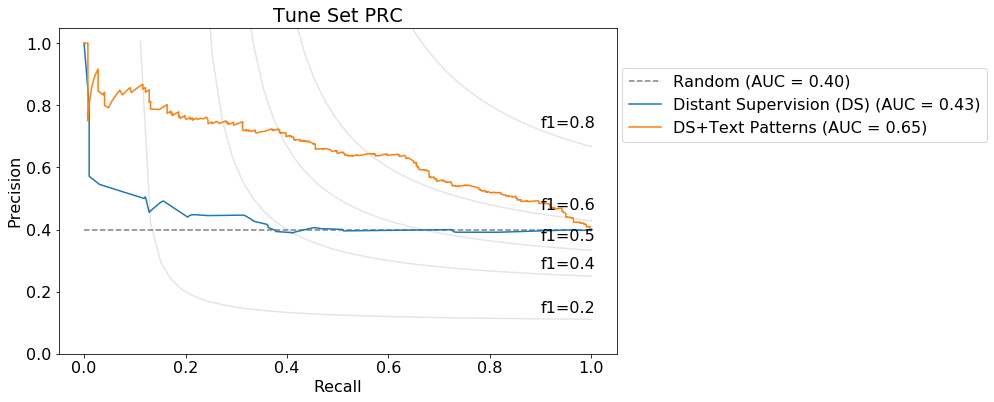

In [37]:
aucs=plot_curve(
    (
        dev_pred_ds_df[["pos_class_marginal"]]
        .rename(index=str, columns={"pos_class_marginal":"Distant Supervision (DS)"})
        .assign(**{"DS+Text Patterns":dev_pred_ds_txt_df.pos_class_marginal.values})
    ),
    candidate_dfs['dev'].curated_dsh, 
    plot_title="Tune Set PRC", 
    metric="PR", model_type="curve"
)

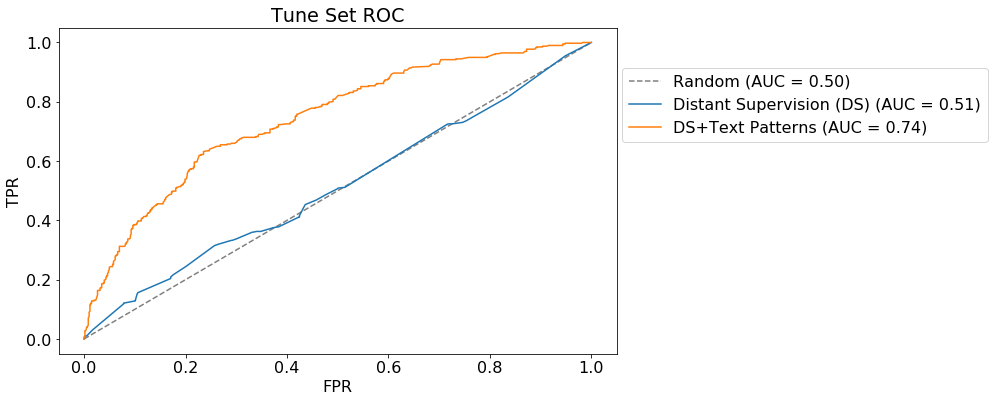

In [38]:
aucs=plot_curve(
    (
        dev_pred_ds_df[["pos_class_marginal"]]
        .rename(index=str, columns={"pos_class_marginal":"Distant Supervision (DS)"})
        .assign(**{"DS+Text Patterns":dev_pred_ds_txt_df.pos_class_marginal.values})
    ),
    candidate_dfs['dev'].curated_dsh, 
    plot_title="Tune Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [39]:
get_auc_significant_stats(
    candidate_dfs['dev'],
    aucs
)

mu: 119695.500000, sigma: 4468.691000


,auroc,u,z_u,p_value
Distant Supervision (DS),0.511874,122538.0,0.636092,2.623581e-01
DS+Text Patterns,0.744437,178211.5,13.094662,1.766207e-39


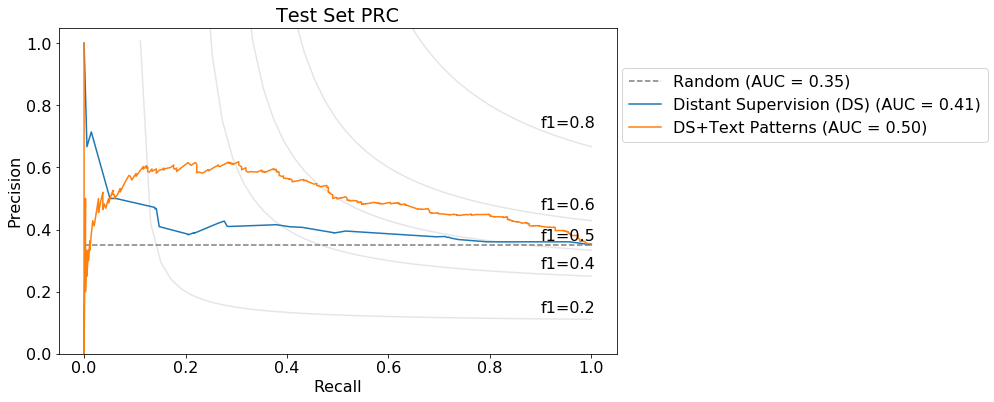

In [40]:
aucs=plot_curve(
    (
        test_pred_ds_df[["pos_class_marginal"]]
        .rename(index=str, columns={"pos_class_marginal":"Distant Supervision (DS)"})
        .assign(**{"DS+Text Patterns":test_pred_ds_txt_df.pos_class_marginal.values})
    ),
    candidate_dfs['test'].curated_dsh, 
    plot_title="Test Set PRC", 
    metric="PR", model_type="curve"
)

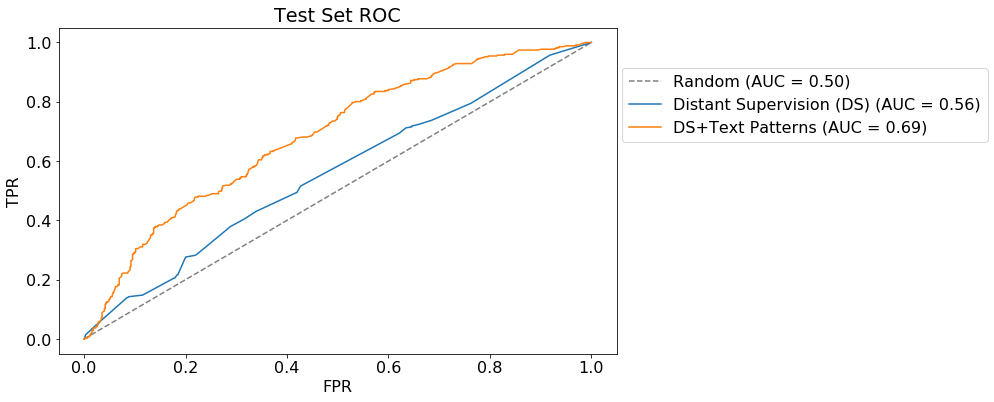

In [41]:
aucs=plot_curve(
    (
        test_pred_ds_df[["pos_class_marginal"]]
        .rename(index=str, columns={"pos_class_marginal":"Distant Supervision (DS)"})
        .assign(**{"DS+Text Patterns":test_pred_ds_txt_df.pos_class_marginal.values})
    ),
    candidate_dfs['test'].curated_dsh, 
    plot_title="Test Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [42]:
get_auc_significant_stats(
    candidate_dfs['test'],
    aucs
)

mu: 113899.500000, sigma: 4359.155107


,auroc,u,z_u,p_value
Distant Supervision (DS),0.555839,126619.5,2.917997,1.761441e-03
DS+Text Patterns,0.685053,156054.5,9.670452,2.012981e-22


## Train Best Model and Output Marginals 

In [43]:
label_model.train_model(
        correct_L, n_epochs=1000, 
        print_every=200, seed=100, lr=0.01, 
        l2=ds_text_reg_df.regularization.values.astype(pd.np.float32)
)

training_marginals_df = pd.DataFrame(
    label_model.predict_proba(correct_L), 
    columns=["pos_class_marginal", "neg_class_marginal"]
)
training_marginals_df['candidate_id'] = (
    total_candidates_df
    .query("split==0&disease_mention_count==1&gene_mention_count==1")
    .candidate_id
    .sort_values()
    .values
)
training_marginals_df.to_csv("data/training_marginals.tsv", sep="\t", index=False)
training_marginals_df.head(2)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 32.021
[E:200]	Train Loss: 2.297
[E:400]	Train Loss: 2.297
[E:600]	Train Loss: 2.297
[E:800]	Train Loss: 2.297
[E:999]	Train Loss: 2.297
Finished Training


,pos_class_marginal,neg_class_marginal,candidate_id
0,0.174847,0.825153,21422
1,0.999967,0.000033,21427


Text(0.5,1,'Histogram of Predicted Likelihoods')

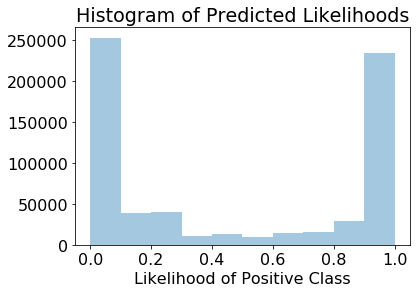

In [104]:
ax = sns.distplot(training_marginals_df.pos_class_marginal, bins=10, kde=False, axlabel="Likelihood of Positive Class")
ax.set_title("Histogram of Predicted Likelihoods")

In [110]:
spreadsheet_name = "data/sentence_gen_dev_error_analysis.xlsx"
writer = pd.ExcelWriter(spreadsheet_name)

(
    candidate_dfs['dev'][[
        "candidate_id", "disease", 
        "gene", "doid_id", "entrez_gene_id",
        "sentence_id", "sentence", "curated_dsh",
        "notes_dsh"
    ]]
    .assign(gen_model=dev_pred_ds_txt_df.pos_class_marginal.values)
    .to_excel(writer, sheet_name='sentences', index=False)
)

if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)

writer.close()

# Word Vectors

This notebook block contains word vectors to be used for the deep learning models. Using facebook's fasttext model, we trained a skipgram model using the sentences in the training set. Each word vector contains 300 dimensions. A validation check for these word embeddings is produced below with the top ten most similar words for diabetes.

In [45]:
if os.path.isfile("data/training_word_vectors.bin"):
    model = KeyedVectors.load_word2vec_format("data/training_word_vectors.bin")
#Train a fasttext model
else:
    model = FastText(words_to_embed, window=2, negative=10, iter=50, sg=1, workers=4, alpha=0.005, size=300, seed=100)
    (
    model
    .wv
    .save_word2vec_format(
        "data/training_word_vectors.bin", 
        fvocab="data/training_word_vocab.txt", 
        binary=False
        )
    )

In [46]:
model.most_similar("diabetes")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pre-diabetes', 0.8766809105873108),
 ('prediabetes', 0.8696415424346924),
 ('mellitus', 0.7737096548080444),
 ('diabetics', 0.7734858989715576),
 ('diabetes-related', 0.7379483580589294),
 ('diabetic', 0.7280935049057007),
 ('obese/diabetic', 0.6865474581718445),
 ('diabetes-associated', 0.6775882244110107),
 ('prediabetics', 0.6699253916740417),
 ('t2dm', 0.6697803139686584)]

In [47]:
from sklearn.manifold import TSNE
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)
tsne_df = pd.DataFrame(tsne.fit_transform(X), index=vocab, columns=["comp_1", "comp_2"])

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Text(0.5,1,'t-SNE Plot of Generated Word Vectors')

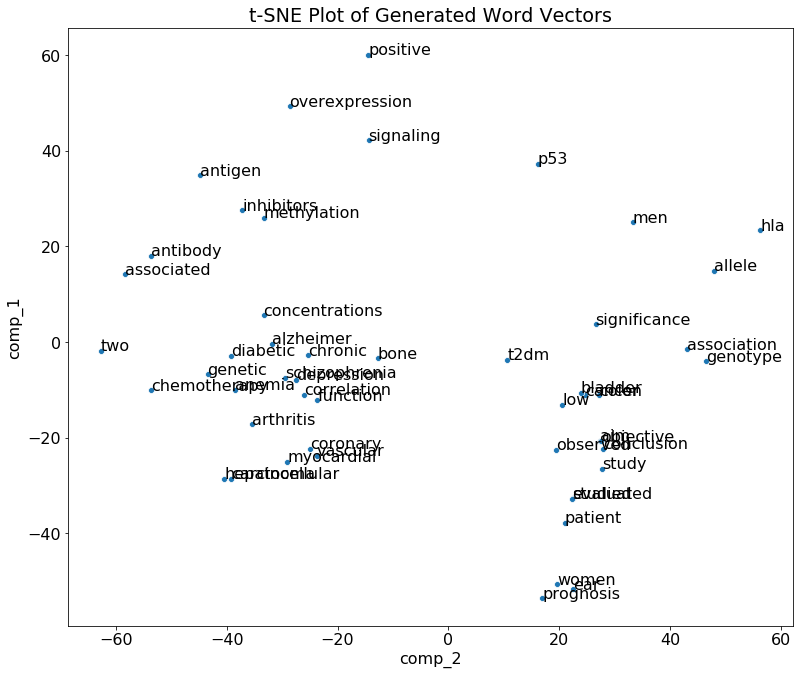

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(13,11)
sample_words = [
        "p53","women","men",
        "patient","genetic","positive",
        "chronic","cancer","carcinoma",
        "t2dm","diabetic","observed",
        "two","prognosis","function",
        "colon","vascular","low",
        "signaling","associated","association",
        "coronary","genotype","hla","ear",
        "methylation","inhibitors","chemotherapy",
        "allele","bladder","overexpression",
        "correlation","aim","study","conclusion",
        "schizophrenia","alzheimer","antibody",
        "myocardial","concentrations","hepatocellular",
        "objective","studied","significance","bone",
        "arthritis","depression","antigen","evaluated","anemia"
]
sns.scatterplot(x="comp_2", y="comp_1", data=tsne_df.loc[sample_words], ax=ax)
for word, pos in tsne_df.loc[sample_words].iterrows():
    ax.annotate(word, (pos['comp_2'], pos['comp_1']))
ax.set_title("t-SNE Plot of Generated Word Vectors")

In [63]:
word_dict_df = pd.DataFrame(
    [(word,idx) for idx, word in enumerate(model.vocab.keys(), 2)], 
    columns=["word", "index"]
)
word_dict_df = word_dict_df.append({"word":'*unknown*', "index":1}, ignore_index=True)
word_dict_df.to_csv("data/word_dictionary.tsv.xz", compression="xz", sep="\t", index=False)
word_dict = {word:index for word, index in word_dict_df[["word", "index"]].values}
word_dict_df.head(2)

,word,index
0,of,2
1,~~[[2,3


In [64]:
def embed_word_to_index(cand):
    return [word_dict[word] if word in word_dict else 1 for word in cand]

In [65]:
def generate_embedded_df(candidates):
    words_to_embed = [
        (
        mark_sentence(
            candidate_to_tokens(cand), 
            [
                    (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                    (cand[1].get_word_start(), cand[1].get_word_end(), 2)
            ]
        ), cand.id)
        for cand in tqdm_notebook(candidates)
    ]
    embed_df = pd.DataFrame(list(map(lambda x: embed_word_to_index(x[0]), words_to_embed)))
    embed_df['candidate_id'] = list(map(lambda x: x[1], words_to_embed))
    embed_df['sen_length'] = list(map(lambda x: len(x[0]), words_to_embed))
    return embed_df

In [69]:
# Code to validate that the embedded rows align with the candidates
candidate_query = (
    total_candidates_df
    .query("split==0&disease_mention_count==1&gene_mention_count==1")
    .head(5)
    .candidate_id
    .astype(int)
    .tolist()
)
# Get the candidates
candidates = session.query(DiseaseGene).filter(DiseaseGene.id.in_(candidate_query)).all()

# Generate the correct output for each word
correct_words_to_embed=[
        (
        mark_sentence(
            candidate_to_tokens(cand), 
            [
                    (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                    (cand[1].get_word_start(), cand[1].get_word_end(), 2)
            ]
        ), cand.id)
        for cand in tqdm_notebook(candidates)
    ]

correct_embedded_words = list(map(lambda x: (embed_word_to_index(x[0]), x[1]), correct_words_to_embed))                            
embedded_train = generate_embedded_df(candidates)

# Confirm the dataframe contains the correct rows for each candidate
for words in correct_embedded_words:
    test_query = embedded_train.query("candidate_id==@words[1]").fillna(0).values.tolist()[0][:-2]
    for pair in zip(words[0], [col for col in test_query if col != 0]):
        assert pair[0] == pair[1]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [70]:
training_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        total_candidates_df
        .query("split==0&disease_mention_count==1&gene_mention_count==1")
        .candidate_id
        .astype(int)
        .tolist()
    ))
    .all()
)
training_data_df.to_csv("data/training_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
training_data_df.head(2)

HBox(children=(IntProgress(value=0, max=658603), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,candidate_id,sen_length
0,64,3,6078,4,16215,17,12,459,5.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33113153,30
1,55,117,294,22,3,3256,4,11,89.0,3483.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21468,44


In [71]:
dev_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        candidate_dfs['dev']['candidate_id']
        .values
        .tolist()
    ))
    .all()
)
dev_data_df.to_csv("data/dev_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
dev_data_df.head(2)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,candidate_id,sen_length
0,9,529,2,2963,72,26,9,14475,436,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21841,63
1,15,36,21,2051,10,8,1,12,394,32771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82680,72


In [72]:
test_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        candidate_dfs['test']['candidate_id']
        .values
        .tolist()
    ))
    .all()
)
test_data_df.to_csv("data/test_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
test_data_df.head(2)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,candidate_id,sen_length
0,3914,192,8,15,10719,10,7465,1016,142,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23356,50
1,9,584,20,3,22521,4,28,66,94,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23367,22
